# 微调大模型:ChatGLM2-6B 进行二分类任务

## 大模型介绍

自 20 世纪 50 年代图灵测试提出以来，人们始终在探索机器处理语言智能的能力。语言本质上是一个错综复杂的人类表达系统，受到语法规则的约束。因此，开发能够理解和精通语言的强大 AI 算法面临着巨大挑战。过去二十年，语言建模方法被广泛用于语言理解和生成，包括统计语言模型和神经语言模型。 

近些年，研究人员通过在大规模语料库上预训练 Transformer 模型产生了预训练语言模型（PLMs），并在解决各类 NLP 任务上展现出了强大的能力。并且研究人员发现模型缩放可以带来性能提升，因此他们通过将模型规模增大进一步研究缩放的效果。有趣的是，当参数规模超过一定水平时，这个更大的语言模型实现了显著的性能提升，并出现了小模型中不存在的能力，比如上下文学习。为了区别于 PLM，这类模型被称为大型语言模型（LLMs）。 

从 2019 年的谷歌 T5 到 OpenAI GPT 系列，参数量爆炸的大模型不断涌现。可以说，LLMs 的研究在学界和业界都得到了很大的推进，尤其去年 11 月底对话大模型 ChatGPT 的出现更是引起了社会各界的广泛关注。LLMs 的技术进展对整个 AI 社区产生了重要影响，并将彻底改变人们开发和使用 AI 算法的方式。

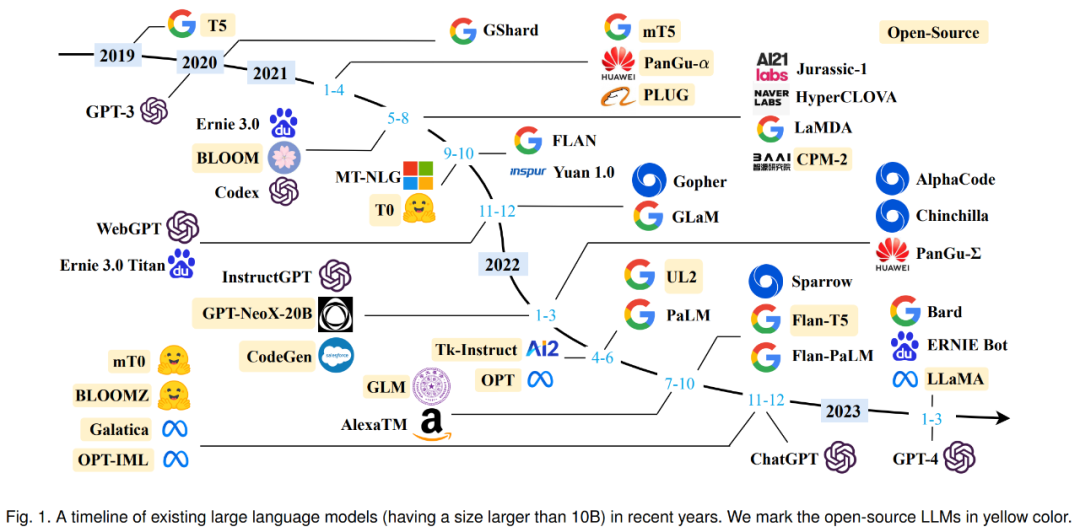

2019 年以来出现的各种大语言模型（百亿参数以上）时间轴，其中标黄的大模型已开源。（2023.04）

(开源大语言模型排行榜地址:<a href="https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard">Open LLM Leaderboard - a Hugging Face Space by HuggingFaceH4</a>)

## 大模型是什么？

通常，大型语言模型（LLM）是指包含数千亿（或更多）参数的语言模型，这些参数是在大量文本数据上训练的，例如模型 GPT-3、PaLM、Galactica 和 LLaMA。具体来说，LLM 建立在 Transformer 架构之上，其中多头注意力层堆叠在一个非常深的神经网络中。现有的 LLM 主要采用与小语言模型类似的模型架构（即 Transformer）和预训练目标（即语言建模）。作为主要区别，LLM 在很大程度上扩展了模型大小、预训练数据和总计算量（扩大倍数）。他们可以更好地理解自然语言，并根据给定的上下文（例如 prompt）生成高质量的文本。这种容量改进可以用标度律进行部分地描述，其中性能大致遵循模型大小的大幅增加而增加。然而根据标度律，某些能力（例如，上下文学习）是不可预测的，只有当模型大小超过某个水平时才能观察到。

像chatgpt、claude AI、文心一言、讯飞星火和通义千问一样的，这种模型通过对大量的文本数据进行学习，可以理解和生成人类的自然语言，甚至可以编程、写数学题。

## 大模型的原理

大语言模型的语言生成的原理叫做自回归模型，是统计上一种处理时间序列的方法。例如现在有一个句子：“我早上去了星巴克”，将其拆分为“我”、“早上”、“去了”、“星巴克”这四个词（我们叫做 token）。大语言模型是这样去学习的：第一个单词是  
，输入到模型中。经过了一个Transformer模块后，它输出希望被训练成第一个字，也就是“我”

在第二个位置，它的输入是“我”，它的输出是“早上”，第三个位置输入是“早上”，输出是“去了”，这样不断地一轮一轮迭代，每个细胞能够根据我现在的这个单词，去预测下一个单词。最后这个模型就能够学到，“我早上去了星巴克”的下一句话应该是“星巴克里的咖啡很好喝”，它认为生成“星巴克里的咖啡很好喝”比“我明天要去乘飞机”这样一句话合理得多。

自回归模型的关键是根据你前面已经出现过的内容，来推测它的下一个字，下一句话应该是怎样生成的，在这样不断的迭代过程中，它就能学会如何去生成一句话、一个段落，以及一篇文章。

总的来说，LLM可以理解为大规模的语言模型。从历史的角度来看，前面说的BERT和GPT并没有达到足够大的规模。直到GPT-2、GPT-3出现了，它们才达到了较大的量级。大家发现语言模型爆炸式增长，从一个细胞长成一个脑子，这种程度上的增长才带来了LLMs。所以我们一般理解LLMs，这个语言模型规模大到了至少到GPT-1或2阶段，它的参数量能够突破1亿或者10亿阶段才能称之为大模型。

## 大模型可以做什么？

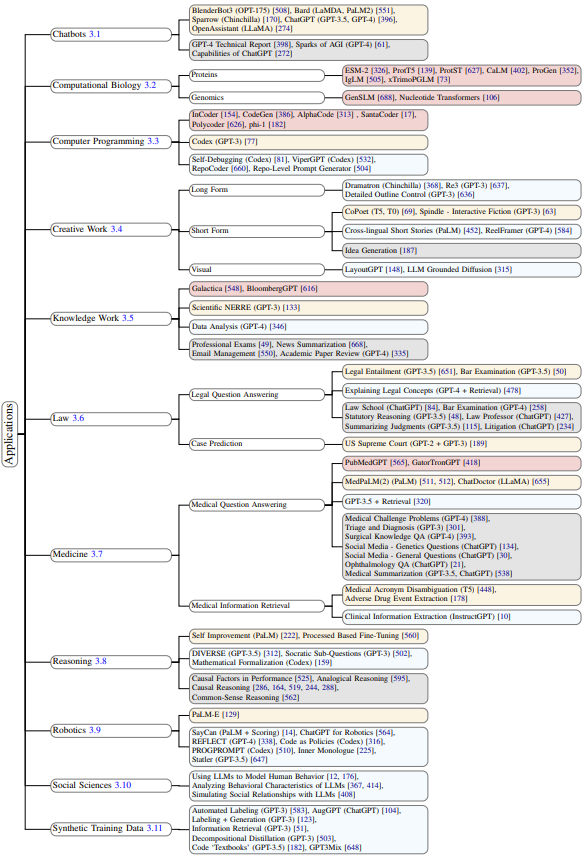

LLM 应用概况。不同颜色表示不同的模型适应程度，包括预训练、微调、提示策略、评估。

## 大模型是如何训练的？

OpenAI 开发 ChatGPT 的三个主要步骤：大尺寸预训练+指令微调+RLHF

1. 大尺寸预训练：在这个阶段，模型在大规模的文本数据集上进行预训练。这是一个非监督学习的过程，模型需要预测在给定的文本序列中下一个词是什么。预训练的目标是让模型学会理解和生成人类语言的基本模式。2. 
指令微调：在预训练之后，模型会在一个更小但专门针对特定任务的数据集上进行微调。这个数据集通常由人工生成，包含了模型需要学会的任务的特定指令。例如，如果我们想要让模型学会如何进行数学计算，我们就需要提供一些包含数学问题和对应解答的数据。3. 
RLHF（Reinforcement Learning from Human Feedback）：这是一个强化学习过程，模型会根据人类提供的反馈进行学习和优化。首先，我们会收集一些模型的预测结果，并让人类评估这些结果的好坏。然后，我们会使用这些评估结果作为奖励，训练模型优化其预测性能。通过这种方式，模型可以学会生成更符合人类期望的结

通过这三个步骤，模型能够在理解和生成人类语言的基础上，更好地完成特定任务，更好地符合人类的期望。果。。

## 什么是大模型微调

将预训练好的语言模型（LM）在下游任务上进行微调已成为处理 NLP 任务的一种范式。与使用开箱即用的预训练 LLM (例如：零样本推理) 相比，在下游数据集上微调这些预训练 LLM 会带来巨大的性能提升。

但是，随着模型变得越来越大，在消费级硬件上对模型进行全部参数的微调（full fine-tuning）变得不可行。

此外，为每个下游任务独立存储和部署微调模型变得非常昂贵，因为微调模型（调整模型的所有参数）与原始预训练模型的大小相同。

因此，近年来研究者们提出了各种各样的参数高效迁移学习方法（Parameter-efficient Transfer Learning），即固定住Pretrain Language model（PLM）的大部分参数，仅调整模型的一小部分参数来达到与全部参数的微调接近的效果（调整的可以是模型自有的参数，也可以是额外加入的一些参数）。

## 微调方法介绍

参考：<a href="https://​blog​.csdn​.net​/sinat​_39620217​/article​/details​/131751780">https://​blog​.csdn​.net​/sinat​_39620217​/article​/details​/131751780</a>

1. LoRA（Low-Rank Adaptation）：它的基本思想是对模型的一部分进行低秩适应，即找到并优化那些对特定任务最重要的部分。也就是冻结预训练好的模型权重参数，在冻结原模型参数的情况下，通过往模型中加入额外的网络层，并只训练这些新增的网络层参数。由于这些新增参数数量较少，这样不仅 finetune 的成本显著下降，还能获得和全模型微调类似的效果。这种方法可以有效地减少模型的复杂性，同时保持模型在特定任务上的表现。对 Transformer 的每一层结构都采用 LoRA 微调的方式，最终可以使得模型微调参数量大大减少。当部署到生产环境中时，只需要计算和存储W=W0+BA，并像往常一样执行推理。与其它方法相比，没有额外的延迟，因为不需要附加更多的层。

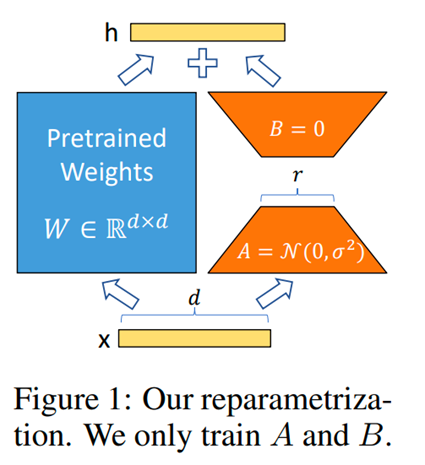

2. P-tuning v2：P-tuning v2是一种新的微调方法，也是chatglm官方仓库使用的微调方法。它的基本思想是在原有的大型语言模型上添加一些新的参数，这些新的参数可以帮助模型更好地理解和处理特定的任务。具体来说，P-tuning v2首先确定模型在处理特定任务时需要的新的参数（这些参数通常是模型的某些特性或功能），然后在模型中添加这些新的参数，以提高模型在特定任务上的表现。

P-tuning v2 官方介绍：<a href="https://​www​.bilibili​.com​/video​/BV1fd4y1Z7Y5">https://​www​.bilibili​.com​/video​/BV1fd4y1Z7Y5</a>

## 建立数据集

目前所称的大语言模型，一般指指令微调大模型，即经过预训练——指令微调——人类反馈强化学习全过程训练的大模型，对人类指令具备较强的理解和执行能力，而不是进行简单的文本生成。例如，当你询问“中国的首都是什么？”时，你的指令即你的问题，通用模型将会简单地对你的问题进行最大概率预测地生成，例如回答“中国的首都是什么？这是一个人尽皆知的问题......”而指令微调大模型会理解你的指令，知道你想要模型对你的问题给出答案，从而回答“北京”。ChatGPT 与 GPT-3 就是鲜明的例子。GPT-3 是通用大模型，因此对你的输入只能进行最大概率预测地输出；而 ChatGPT 是指令微调大模型，可以理解并执行你的指令，例如帮助你写代码，帮助你判断问题等。

正如其名，指令微调大模型与通用大模型最大的区别在于进行了指令微调，即训练模型理解并执行指令的能力。指令微调一般会给模型特定的指令及执行指令后的输出，要求模型学习遵循指令的能力。这里的指令可以有很多种类型，包括回答问题、续写、创作等。具体而言，指令微调时通常有两个输入，一个是你要求模型执行的指令，另一个是执行该指令所必须的输入。例如，当你要求模型执行指令“续写我的话”，那么你还需要输入该指令中指代的话，例如“今天天气很好，我们去”。而指令微调的输出一般是模型执行该指令后的输出，例如对于上述示例，输出应该为“郊游吧”。

本任务中，我们所要对大模型进行的即是指令微调。通过训练模型在特定指令（在本任务中，即要求其判断文献是否医学领域文献）下的指令执行能力，来使用大模型完成本任务。我们也需要按照指令微调的格式进行数据集的建立。使用 LoRA 进行指令微调时，数据集一般有三个元素：instruction，input，output。instruction 即指令，即上文中我们所提到的第一个输入——要求模型执行的指令。input 即上文中我们提到的第二个输入——执行该指令所必须的输入。output 即指令微调的输出。

对于各种下游任务，只需要对应去构造特定的指令与输入即可。例如，在本次任务中，我们需要让大模型实现文本分类任务，那我们构造的指令、输入与输出应该为：

- instruction：指令，Please judge whether it is a medical field paper according to the given paper title and abstract, output 1 or 0, the following is the paper title and abstract -->
- "-->":加上一个箭头就是让大模型明白，下次再遇到这种问题，就是我们想让大模型进行二分类任务。
- input：prompt。对于这个任务来说那就是 title+abstract+author 拼接成的字符串了。
- output：response，即大模型的回答，0 or 1。

如果是对于任务二的关键词生成，那么我们应该将指令修改为要求模型根据给定文献的标题、摘要生成关键词，输入不变，输出更改为文献的关键词：

- instruction：指令，Please extract keywords from the given paper title and abstract in the text below, separated by commas -->
- "-->":加上一个箭头就是让大模型明白，下次再遇到这种问题，就是我们想让大模型进行关键词抽取任务。
- input：prompt。对于这个任务来说那就是 title+abstract+author 拼接成的字符串了。
- output：response，即大模型的回答，具体抽取出的关键词。

## 配置

In [ ]:
# clone微调脚本
git clone https://github.com/KMnO4-zx/xfg-paper.git

# 下载chatglm2-6b模型
git clone https://huggingface.co/THUDM/chatglm2-6b

# 如果卡在中间也可以在确保git clone https://​huggingface​.co​/THUDM​/chatglm2​-6b执行成功但无反应后，进入''chatglm2-6b''文件下，用如下命令下载模型【慎用】
# 此命令只用于下载模型文件，py文件不会下载。
wget https://cloud.tsinghua.edu.cn/seafhttp/files/f3e22aa1-83d1-4f83-917e-cf0d19ad550f/pytorch_model-00001-of-00007.bin https://cloud.tsinghua.edu.cn/seafhttp/files/0b6a3645-0fb7-4931-812e-46bd2e8d8325/pytorch_model-00002-of-00007.bin https://cloud.tsinghua.edu.cn/seafhttp/files/f61456cb-5283-4529-a7bc-400355140e4b/pytorch_model-00003-of-00007.bin https://cloud.tsinghua.edu.cn/seafhttp/files/1a1f68c5-1a7d-489a-8f16-8432a099d782/pytorch_model-00004-of-00007.bin https://cloud.tsinghua.edu.cn/seafhttp/files/6357afba-bb40-4348-bc33-f08c1fcc2936/pytorch_model-00005-of-00007.bin  https://cloud.tsinghua.edu.cn/seafhttp/files/ebec3ae2-5ae4-432c-83e4-df4b147026bb/pytorch_model-00006-of-00007.bin https://cloud.tsinghua.edu.cn/seafhttp/files/7d1aab8a-d255-47f7-87c9-4c0593379ee9/pytorch_model-00007-of-00007.bin https://cloud.tsinghua.edu.cn/seafhttp/files/4daca87e-0d34-4cff-bd43-5a40fcdf4ab1/tokenizer.model

# 进入目录安装环境
cd ./xfg-paper
pip install -r requirements.txt

# 将脚本中的model_name_or_path更换为你本地的chatglm2-6b模型路径，然后运行脚本
sh xfg_train.sh

In [ ]:
CUDA_VISIBLE_DEVICES=0 python src/train_bash.py \
    --model_name_or_path chatglm2-6b \ 本地模型的目录
    --stage sft \ 微调方法
    --use_v2 \ 使用glm2模型微调，默认值true
    --do_train \ 是否训练，默认值true
    --dataset paper_label \ 数据集名字
    --finetuning_type lora \
    --lora_rank 8 \  LoRA 微调中的秩大小
    --output_dir ./output/label_xfg \ 输出lora权重存放目录
    --per_device_train_batch_size 4 \ 用于训练的批处理大小
    --gradient_accumulation_steps 4 \ 梯度累加次数
    --lr_scheduler_type cosine \
    --logging_steps 10 \ 日志输出间隔
    --save_steps 1000 \ 断点保存间隔
    --learning_rate 5e-5 \ 学习率
    --num_train_epochs 4.0 \ 训练轮数
    --fp16 是否使用 fp16 半精度 默认值：False


## 导入数据

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('./csv_data/train.csv')
testB_df = pd.read_csv('./csv_data/testB.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   uuid      6000 non-null   int64 
 1   title     6000 non-null   object
 2   author    6000 non-null   object
 3   abstract  6000 non-null   object
 4   Keywords  6000 non-null   object
 5   label     6000 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 281.4+ KB


## 制作数据集

In [4]:
res = []

for i in range(len(train_df)):
    paper_item = train_df.loc[i]
    tmp = {
    "instruction": "Please judge whether it is a medical field paper according to the given paper title and abstract, output 1 or 0, the following is the paper title and abstract -->",
    "input": f"title:{paper_item[1]},abstract:{paper_item[3]}",
    "output": str(paper_item[5])
  }
    res.append(tmp)

In [5]:
import json

with open('./data/paper_label.json', mode='w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False, indent=4)

## 微调chatglm2-6b

- 首先需要clone微调脚本：`git clone https://github.com/LLLM-Lab/xfg-paper.git`
- 进入目录安装环境：`cd ./xfg-paper`；`pip install -r requirements.txt `
- 将脚本中的`model_name_or_path`更换为你本地的chatglm2-6b模型路径，然后运行脚本：`sh xfg_train.sh`

微调过程大概需要两个小时（我使用了阿里云A10-24G运行了两个小时左右），微调过程需要16G的显存，推荐使用24G显存的显卡，比如3090，4090等。

当然，我已经把训练好的lora权重放在了仓库里，您可以直接运行下面的代码。

## 加载训练好的LoRA权重，进行预测

In [6]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModel, GenerationConfig, AutoModelForCausalLM

model_path = "../chatglm2-6b"
model = AutoModel.from_pretrained(model_path, trust_remote_code=True).half().cuda()
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# 加载 label lora权重
model = PeftModel.from_pretrained(model, './output/label_xfg').half()
model = model.eval()
response, history = model.chat(tokenizer, "你好", history=[])
response

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


'你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。'

In [7]:
# 预测函数

def predict(text):
    response, history = model.chat(tokenizer, f"Please judge whether it is a medical field paper according to the given paper title and abstract, output 1 or 0, the following is the paper title, author and abstract -->{text}", history=[],
    temperature=0.01)
    return response

In [8]:
predict('title:Seizure Detection and Prediction by Parallel Memristive Convolutional Neural Networks,author:Li, Chenqi; Lammie, Corey; Dong, Xuening; Amirsoleimani, Amirali; Azghadi, Mostafa Rahimi; Genov, Roman,abstract:During the past two decades, epileptic seizure detection and prediction algorithms have evolved rapidly. However, despite significant performance improvements, their hardware implementation using conventional technologies, such as Complementary Metal-Oxide-Semiconductor (CMOS), in power and areaconstrained settings remains a challenging task; especially when many recording channels are used. In this paper, we propose a novel low-latency parallel Convolutional Neural Network (CNN) architecture that has between 2-2,800x fewer network parameters compared to State-Of-The-Art (SOTA) CNN architectures and achieves 5-fold cross validation accuracy of 99.84% for epileptic seizure detection, and 99.01% and 97.54% for epileptic seizure prediction, when evaluated using the University of Bonn Electroencephalogram (EEG), CHB-MIT and SWEC-ETHZ seizure datasets, respectively. We subsequently implement our network onto analog crossbar arrays comprising Resistive Random-Access Memory (RRAM) devices, and provide a comprehensive benchmark by simulating, laying out, and determining hardware requirements of theCNNcomponent of our system. We parallelize the execution of convolution layer kernels on separate analog crossbars to enable 2 orders of magnitude reduction in latency compared to SOTA hybrid Memristive-CMOS Deep Learning (DL) accelerators. Furthermore, we investigate the effects of non-idealities on our system and investigate Quantization Aware Training (QAT) to mitigate the performance degradation due to lowAnalog-to-Digital Converter (ADC)/Digital-to-Analog Converter (DAC) resolution. Finally, we propose a stuck weight offsetting methodology to mitigate performance degradation due to stuck RON/ROFF memristor weights, recovering up to 32% accuracy, without requiring retraining. The CNN component of our platform is estimated to consume approximately 2.791Wof power while occupying an area of 31.255 mm(2) in a 22 nm FDSOI CMOS process.')

'1'

In [9]:
# 预测测试集

from tqdm import tqdm

label = []

for i in tqdm(range(len(testB_df))):
    test_item = testB_df.loc[i]
    test_input = f"title:{test_item[1]},author:{test_item[2]},abstract:{test_item[3]}"
    label.append(int(predict(test_input)))


100%|██████████| 2000/2000 [05:50<00:00,  5.70it/s]


In [15]:
testB_df['label'] = label
testB_df['Keywords'] = ['tmp' for _ in range(2000)]

In [16]:
testB_df

,uuid,title,author,abstract,label,Keywords
0,0,Tobacco Consumption and High-Sensitivity Cardi...,"Julia Brox Skranes,Magnus Nakrem Lyngbakken,Kr...",Background Cardiac troponins represent a sensi...,1,tmp
1,1,Approaching towards sustainable supply chain u...,"Mohammad Reza Seddigh,Sajjad Shokouhyar,Fateme...",These two main objectives of this study are to...,1,tmp
2,2,Does globalization matter for ecological footp...,"Kirikkaleli, Dervis; Adebayo, Tomiwa Sunday; K...",The main aim of this paper is to explore the r...,0,tmp
3,3,Myths and Misconceptions About University Stud...,"Megan Paull,Kirsten Holmes,Maryam Omari,Debbie...",This paper examines myths and misconceptions a...,1,tmp
4,4,Antioxidant Status of Rat Liver Mitochondria u...,"S I Khizrieva,R A Khalilov,A M Dzhafarova,V R ...",For evaluation of the contribution of the anti...,1,tmp
...,...,...,...,...,...,...
1995,1995,The treatment of veterinary antibiotics in swi...,"Qian, Mengcheng; Yang, Linyan; Chen, Xingkui; ...",Elevated concentrations and potential toxiciti...,0,tmp
1996,1996,Socio-political efficacy explains increase in ...,"Taciano L Milfont,Danny Osborne,Chris G Sibley...",The ongoing COVID-19 pandemic claimed millions...,1,tmp
1997,1997,Investigation of early puberty prevalence and ...,"Esin Gizem Olgun,Sirmen Kizilcan Cetin,Zeynep ...",We aimed to determine the prevalence of early ...,1,tmp
1998,1998,From 3D printing to 3D bioprinting: the materi...,"Nihal Engin Vrana,Sharda Gupta,Kunal Mitra,Alb...",The application of 3D printing technologies fi...,1,tmp


In [17]:
submit = testB_df[['uuid', 'Keywords', 'label']]

In [18]:
submit

,uuid,Keywords,label
0,0,tmp,1
1,1,tmp,1
2,2,tmp,0
3,3,tmp,1
4,4,tmp,1
...,...,...,...
1995,1995,tmp,0
1996,1996,tmp,1
1997,1997,tmp,1
1998,1998,tmp,1


In [19]:
submit.to_csv('submit.csv', index=False)